In [26]:
from Brain_Loader_Preprocessing import *
from finetune_resnet50 import *
from sklearn.preprocessing import LabelEncoder

In [3]:
load_data = BrainMRIDataLoader('images', ['Healthy', 'Tumor'])
df = load_data.load_data()

------------ Status of the data load ------------
* data loaded successfully
-------------------------------------------------- 



In [4]:
df.head()

,image_path,label
0,images\Healthy\mri_healthy (1).jpeg,Healthy
1,images\Healthy\mri_healthy (1).jpg,Healthy
2,images\Healthy\mri_healthy (10).jpg,Healthy
3,images\Healthy\mri_healthy (100).jpg,Healthy
4,images\Healthy\mri_healthy (1000).jpg,Healthy


In [12]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])
print(df.head())
print(df['category_encoded'].value_counts())


                              image_path    label  category_encoded
0    images\Healthy\mri_healthy (1).jpeg  Healthy                 0
1     images\Healthy\mri_healthy (1).jpg  Healthy                 0
2    images\Healthy\mri_healthy (10).jpg  Healthy                 0
3   images\Healthy\mri_healthy (100).jpg  Healthy                 0
4  images\Healthy\mri_healthy (1000).jpg  Healthy                 0
category_encoded
1    3000
0    2000
Name: count, dtype: int64


In [13]:
print(f"Clases codificadas: {label_encoder.classes_} -> {label_encoder.transform(label_encoder.classes_)}")



Clases codificadas: ['Healthy' 'Tumor'] -> [0 1]


In [4]:
df = Brain_preprocessing(df)

In [12]:
df.category_encoder()

-------------------------------------------------- 

* Categorical labels encoded successfully.

                            image_path    label  category_encoded
0  images\Healthy\mri_healthy (1).jpeg  Healthy                 0
1   images\Healthy\mri_healthy (1).jpg  Healthy                 0
2  images\Healthy\mri_healthy (10).jpg  Healthy                 0
-------------------------------------------------- 

* Encoded class distribution:
category_encoded
1    3000
0    2000
Name: count, dtype: int64
Clases codificadas: ['Healthy' 'Tumor'] -> [0 1]
-------------------------------------------------- 



In [13]:
train_df, val_df, test_df = df.train_val_test_split(0.2, 42)

* Train/Validation/Test split completed successfully.

Training set size: 4000
Validation set size: 500
Test set size: 500
-------------------------------------------------- 



In [16]:
train_df

,image_path,label,category_encoded
4882,images\Tumor\tumor (510).jpg,Tumor,1
684,images\Healthy\mri_healthy (1613).jpg,Healthy,0
3228,images\Tumor\meningioma (499).jpg,Tumor,1
2505,images\Tumor\glioma (554).jpg,Tumor,1
1480,images\Healthy\mri_healthy (530).jpg,Healthy,0
...,...,...,...
2277,images\Tumor\glioma (349).jpg,Tumor,1
3353,images\Tumor\meningioma (610).jpg,Tumor,1
1172,images\Healthy\mri_healthy (254).jpg,Healthy,0
2486,images\Tumor\glioma (537).jpg,Tumor,1


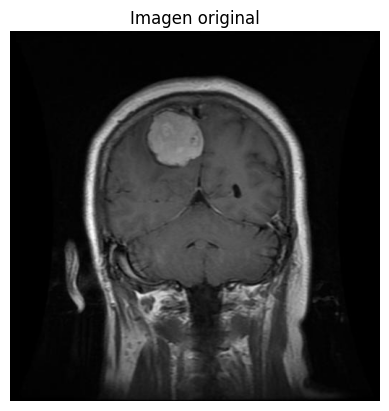

In [23]:
import matplotlib.pyplot as plt
from PIL import Image

# Visualiza una imagen original
img_path = train_df['image_path'].iloc[0]
img = Image.open(img_path)
plt.imshow(img)
plt.title("Imagen original")
plt.axis('off')
plt.show()

In [24]:
from generators import DataGenerator

# Configura el generador de datos
data_gen = DataGenerator(batch_size=32, img_size=(224, 224))
train_df['category_encoded'] = train_df['category_encoded'].astype(str)
val_df['category_encoded'] = val_df['category_encoded'].astype(str)
test_df['category_encoded'] = test_df['category_encoded'].astype(str)
train_datagen = data_gen.get_train_datagen()

# Crea el generador a partir de tu DataFrame de entrenamiento
train_gen = data_gen.get_generator(train_df, train_datagen, shuffle=True)

Found 4000 validated image filenames belonging to 2 classes.


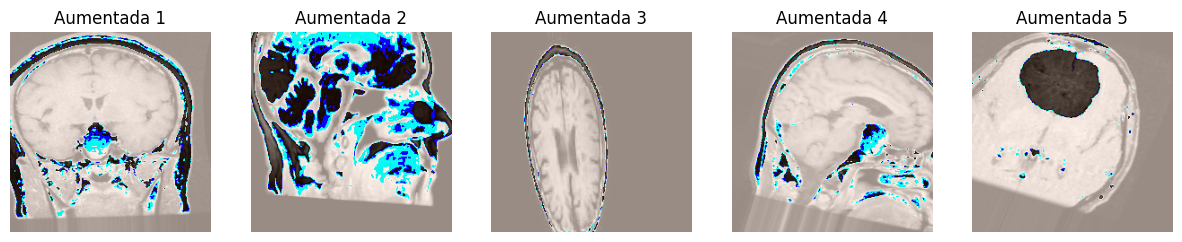

In [25]:
# Obtén un lote de imágenes aumentadas
images, labels = next(train_gen)

# Muestra las primeras 5 imágenes aumentadas
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(f"Aumentada {i+1}")
    plt.axis('off')
plt.show()

In [29]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from generators import DataGenerator

# Configura el generador de datos (ajusta batch_size e img_size si es necesario)
data_gen = DataGenerator(batch_size=32, img_size=(224, 224))
test_datagen = data_gen.get_test_datagen()

# Asegúrate de que la columna sea string
test_df['category_encoded'] = test_df['category_encoded'].astype(str)

# Crea el generador de test
test_gen = data_gen.get_generator(test_df, test_datagen, shuffle=False)

finetuner = ResNet50FineTuner()

# Cargar el modelo entrenado
finetuner.model = load_model('best_resnet_model.h5')

# Evaluar en el conjunto de prueba
results = finetuner.model.evaluate(test_gen, verbose=1)
metric_names = finetuner.model.metrics_names
print("\nMétricas de evaluación en el conjunto de prueba:")
for name, value in zip(metric_names, results):
    print(f"{name}: {value:.4f}")

# Matriz de confusión y reporte de clasificación
y_true = test_df['category_encoded'].astype(int).values
y_pred_probs = finetuner.model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusión:\n", cm)
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Tumor']))

Found 500 validated image filenames belonging to 2 classes.
16/16 [==============================] - 4s 180ms/step - loss: 0.0475 - accuracy: 0.9980 - auc: 1.0000 - recall: 1.0000 - precision: 0.9967

Métricas de evaluación en el conjunto de prueba:
loss: 0.0475
accuracy: 0.9980
auc: 1.0000
recall: 1.0000
precision: 0.9967
16/16 [==============================] - 4s 180ms/step
Matriz de confusión:
 [[199   1]
 [  0 300]]
              precision    recall  f1-score   support

     Healthy       1.00      0.99      1.00       200
       Tumor       1.00      1.00      1.00       300

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [30]:
print(test_df['image_path'].head())


1147    images\Healthy\mri_healthy (231).jpg
3005       images\Tumor\meningioma (298).jpg
3271       images\Tumor\meningioma (537).jpg
4185        images\Tumor\pituitary (460).jpg
4398         images\Tumor\pituitary (86).jpg
Name: image_path, dtype: object
